# X1 Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

C:\Users\braun\AppData\Local\Temp\ipykernel_46840\3973438280.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd

### Download the data from [GDrive](https://drive.google.com/file/d/1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g/view?usp=drivesdk) into your local folder

### or download the data from the notebook

In [3]:
import gdown

# Google Drive file ID from the shareable link
file_id = "1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g"  # Replace with actual file ID
output_path = "./01_segmentation.tar.gz"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Download file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g
From (redirected): https://drive.google.com/uc?id=1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g&confirm=t&uuid=f89a30d7-9ba7-4d3d-9604-87daa07983fb
To: c:\Users\braun\OneDrive\Documents\GitHub\DataScienceForElectronMicroscopy\notebooks\01_segmentation.tar.gz
100%|██████████| 918M/918M [00:09<00:00, 101MB/s]  

'./01_segmentation.tar.gz'

In [4]:
import tarfile
import os

# Create the target directory if it doesn't exist
os.makedirs("01_segmentation", exist_ok=True)

# Extract the tar.gz file into the 01_segmentation directory
with tarfile.open("01_segmentation.tar.gz", "r:gz") as tar:
    tar.extractall("01_segmentation")



## Let’s load the data and display some examples

In [5]:
file_path = './01_segmentation/optimal_Au/images/'

print("Folders in file_path:")
folders = [f for f in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, f))]
for folder in folders[:5]:
    print(f"- {folder}")

Folders in file_path:
- image_batch_52018624472_20240403
- image_batch_52022266961_20240403
- image_batch_52026386826_20240403
- image_batch_52026537584_20240403
- image_batch_52033186249_20240403

## Get all .h5 files from all subfolders

In [6]:

h5_files = []
for folder in folders:
    folder_path = os.path.join(file_path, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    h5_files.extend([os.path.join(folder_path, f) for f in files])

print(f"\nFound {len(h5_files)} .h5 files:")
for f in h5_files[:5]:  # Print first 5 files as example
    print(f"- {f}")
if len(h5_files) > 5:
    print("...")


Found 128 .h5 files:
- ./01_segmentation/optimal_Au/images/image_batch_52018624472_20240403\image_batch.h5
- ./01_segmentation/optimal_Au/images/image_batch_52022266961_20240403\image_batch.h5
- ./01_segmentation/optimal_Au/images/image_batch_52026386826_20240403\image_batch.h5
- ./01_segmentation/optimal_Au/images/image_batch_52026537584_20240403\image_batch.h5
- ./01_segmentation/optimal_Au/images/image_batch_52033186249_20240403\image_batch.h5
...

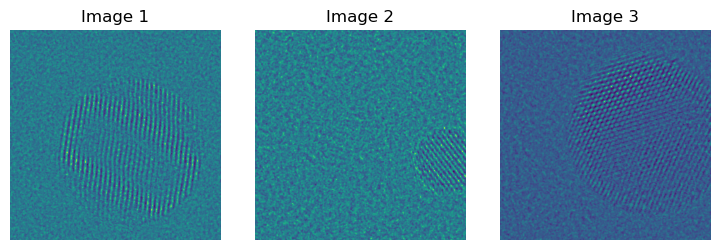

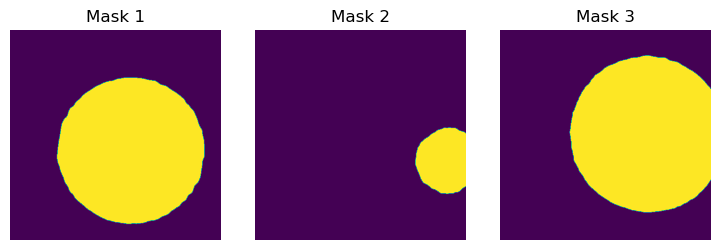

In [7]:
file_names = h5_files[0]

with h5.File(file_names, 'r') as f:
    d = f['train_batch'][...]
    m = f['mask_batch'][...]
   

fig, axes = plt.subplots(1, 3, figsize=(15/2, 5/2))
for i in range(3):
    axes[i].imshow(d[i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')
plt.tight_layout()
plt.show()
# Plot first 3 masks
fig, axes = plt.subplots(1, 3, figsize=(15/2, 5/2))
for i in range(3):
    axes[i].imshow(m[i])
    axes[i].axis('off') 
    axes[i].set_title(f'Mask {i+1}')
plt.tight_layout()
plt.show()

# %%

In [8]:
d.shape, m.shape

((64, 512, 512), (64, 512, 512))

In [13]:
class SegmentationDataset:
    def __init__(self, file_paths):
        self.file_paths = file_paths
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5.File(file_path, 'r') as f:
            # Load image and mask from h5 file
            image = f['train_batch'][...]
            mask = f['mask_batch'][...]
        return image, mask

# Create dataset instance
dataset = SegmentationDataset(h5_files)

# Test loading first item
images, masks = dataset[0]
print(f"Loaded images shape: {images.shape}")
print(f"Loaded masks shape: {masks.shape}")


Loaded images shape: (64, 512, 512)
Loaded masks shape: (64, 512, 512)

In [14]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(128, 64)
        
        # Final output
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)
        conv5 = self.conv5(pool4)
        
        # Decoder with skip connections
        up4 = self.up4(conv5)
        up4 = torch.cat([up4, conv4], dim=1)
        up4 = self.upconv4(up4)
        
        up3 = self.up3(up4)
        up3 = torch.cat([up3, conv3], dim=1)
        up3 = self.upconv3(up3)
        
        up2 = self.up2(up3)
        up2 = torch.cat([up2, conv2], dim=1)
        up2 = self.upconv2(up2)
        
        up1 = self.up1(up2)
        up1 = torch.cat([up1, conv1], dim=1)
        up1 = self.upconv1(up1)
        
        out = self.outconv(up1)
        return out

# Create model instance
model = UNet(in_channels=1, out_channels=1)



In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders
batch_size = 4
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Training parameters
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print statistics every 10 batches
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Print epoch statistics
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] complete. Average Loss: {epoch_loss:.4f}')

print('Training finished!')
